In [1]:
cd ..

/Users/abrahamflamholz/Documents/workspace/carboxecoli


In [2]:
import seaborn as sns
import numpy as np
import optslope_rubisco

from cobra.io import read_sbml_model
from cobra.core import model
from importlib_resources import read_text
from optslope import calculate_slope, plot_production_envelope, production_envelope
from optslope import models
from typing import List, Tuple, Iterable, Any

import matplotlib.pyplot as plt

In [3]:
# modified version of plotting.plot_production_envelope
# let's us put multiple planes on the same plot. 
def plot_envelope(
        wt_model: model,
        knockouts: Iterable[str],
        carbon_sources: Iterable[str],
        target_reaction: str,
        ax: plt.Axes,
        label: str = None,
        color: Any = 'b'):
    prod_env_df = production_envelope(
        wt_model=wt_model,
        knockouts=knockouts,
        carbon_sources=carbon_sources,
        target_reaction=target_reaction)

    label = label or ','.join(carbon_sources)
    ax.plot(prod_env_df.flux_minimum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=2, label='')
    ax.plot(prod_env_df.flux_maximum,
            prod_env_df[target_reaction],
            c=color, ls='-', lw=2, label='')

    ax.fill_betweenx(
        prod_env_df[target_reaction],
        prod_env_df.flux_minimum,
        prod_env_df.flux_maximum,
        linewidth=0,
        alpha=0.4,
        facecolor=color,
        label=label)

In [15]:
# Extend the wild-type model to include Rubisco, Prk and the ED pathway
# as well as export reaction for a number of central metabolites. 
wt_model = read_sbml_model(read_text(optslope_rubisco, optslope_rubisco.WILDTYPE_MODEL))

# Note that we are using these intracellular metabolites as proxy for carbon sources
# xu5p = xylulose-5p, proxy for extracellular xylose
# dhap = dihydroxyacetone-p, proxy for extracellular glycerol
# g6p = glucose-6p, proxy for extracellular glucose.
# f6p = fructose-6p, proxy for extracellular fructose.
# r5p = ribose-5p, proxy for extracellular ribose.
# 2pg = gylcerate-2p, not to be confused with Rubisco product 2-phosphoglycolate. Proxy for glycerate. 
# e4p = erythrose-4p, proxy for tetroses.
# 6pgc = gluconate-6p, proxy for gluconate. 

# Rich media is just everything the model can eat. 
all_csources = [c[0] for c in optslope_rubisco.CARBON_SOURCES_LIST]
rich_media = all_csources+['pyr', 'xu5p__D']

# Colors for plotting
colors = sns.color_palette('muted')
cmap = {'xylose': colors[0],
        'glycerol': colors[1],
        'glucose': colors[2],
        'pyruvate': colors[3], 
        'gluconate': colors[4]}

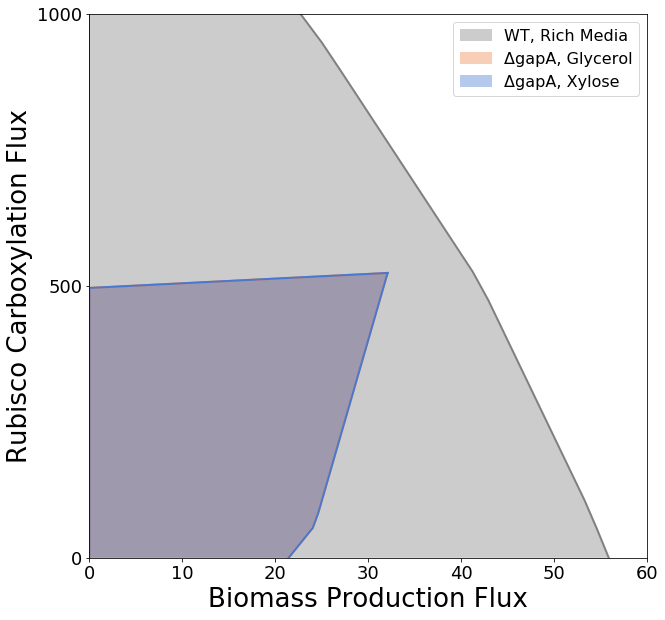

In [16]:
# gapA KO was previously published by Mueller-Cajar '07 and others.
# Plot shows that this strain has slope 0 on sample carbon sources.
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# plot WT on rich media
plot_envelope(
    wt_model,
    knockouts=[],
    carbon_sources=rich_media,
    target_reaction="RBC",
    ax=ax,
    label='WT, Rich Media',
    color='grey')

mut_name = "ΔgapA"
csources = [('dhap', 'glycerol'), ('xu5p__D', 'xylose'), ]
for i, (csource, csource_name) in enumerate(csources):
    # plot gapA mutant
    c = cmap[csource_name]
    label = '%s, %s' % (mut_name, csource_name.title())
    plot_envelope(
        wt_model,
        knockouts=['GAPD'],
        carbon_sources=[csource],
        target_reaction="RBC",
        ax=ax,
        label=label,
        color=c)

plt.xlabel('Biomass Production Flux', fontsize=26)
plt.ylabel('Rubisco Carboxylation Flux', fontsize=26)
plt.xticks(np.arange(0, 65, 10), fontsize=18)
plt.yticks(np.arange(0, 1001, 500), fontsize=18)
plt.xlim(0, 60)
plt.ylim(0, 1000)

plt.legend(fontsize=16)
plt.show()

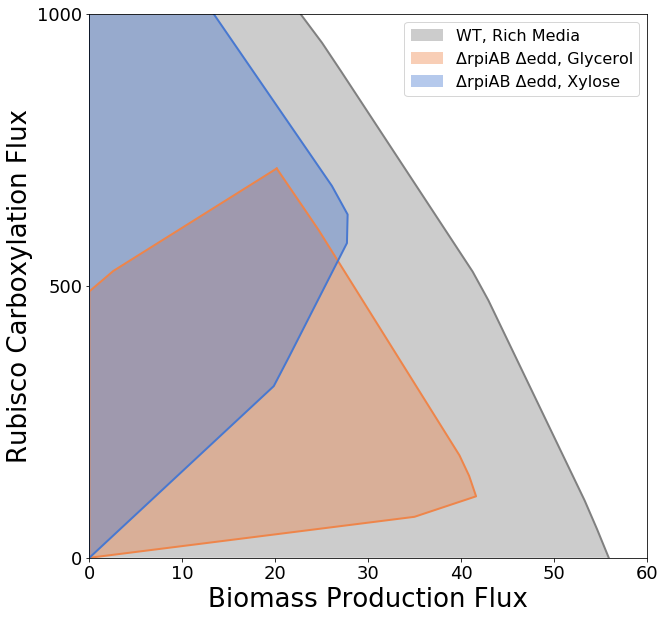

In [17]:
# rpiAB KO has a slope on several carbon sources, as plotted below.
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# plot WT
plot_envelope(
    wt_model,
    knockouts=[],
    carbon_sources=rich_media,
    target_reaction="RBC",
    ax=ax,
    label='WT, Rich Media',
    color='grey')

mut_name = "ΔrpiAB Δedd"
csources = [('dhap', 'glycerol'), ('xu5p__D', 'xylose')]

for i, (csource, csource_name) in enumerate(csources):
    # plot gapA mutant
    c = cmap[csource_name]
    label = '%s, %s' % (mut_name, csource_name.title())
    plot_envelope(
        wt_model,
        knockouts=['RPI', 'EDD'],
        carbon_sources=[csource],
        target_reaction="RBC",
        ax=ax,
        label=label,
        color=c)

plt.xlabel('Biomass Production Flux', fontsize=26)
plt.ylabel('Rubisco Carboxylation Flux', fontsize=26)
plt.xticks(np.arange(0, 65, 10), fontsize=18)
plt.yticks(np.arange(0, 1001, 500), fontsize=18)
plt.xlim(0, 60)
plt.ylim(0, 1000)

plt.legend(fontsize=16)
plt.show()